<a href="https://colab.research.google.com/github/TrippleA001/Air-Quality-Index-for-Urban-vs-Rural-Nigeria/blob/main/Individual/Abuja_PM10_pollutants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR

# To encode categorical variables
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
df= pd.ExcelFile("/content/drive/MyDrive/PM 2.5 and PM 10 Prediction for PhD Physics/Abuja's Data.xlsx")
data = pd.read_excel(df, 'Hourly')

Mounted at /content/drive/


In [ ]:
data

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
0,2021-05-01,01:00:00,25.74,78.63,960.42,3.10,204.53,27.4095,36.3010,46.6625
1,2021-05-01,02:00:00,25.30,81.62,959.98,2.63,205.55,28.5125,37.6835,48.5435
2,2021-05-01,03:00:00,24.86,84.55,959.73,2.03,209.80,33.8070,44.3545,57.4715
3,2021-05-01,04:00:00,24.48,86.96,959.83,1.61,220.12,36.7465,47.5705,62.3160
4,2021-05-01,05:00:00,24.18,88.91,960.10,1.46,239.72,35.2185,45.7880,60.5980
...,...,...,...,...,...,...,...,...,...,...
12749,2023-04-30,19:00:00,26.70,72.89,962.02,1.21,203.39,31.4885,38.2285,47.1120
12750,2023-04-30,20:00:00,25.82,77.90,962.56,1.85,197.49,26.7210,34.3800,41.3970
12751,2023-04-30,21:00:00,25.06,81.28,963.04,2.31,193.28,26.1080,33.5455,40.2245
12752,2023-04-30,22:00:00,24.42,84.06,963.30,2.42,190.59,28.6175,36.9825,45.2260


In [ ]:
# summary statistics for the data used in buiding the ML algorithms
data.describe()

,Date,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
count,12754,12754.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000
mean,2022-05-05 08:36:05.532382208,25.171845,70.038970,963.162076,2.452144,176.241571,29.950514,41.176223,51.209227
min,2021-05-01 00:00:00,-273.150000,11.780000,956.200000,0.030000,0.010000,1.190000,1.855000,2.050000
25%,2021-11-14 00:00:00,22.350000,56.170000,961.940000,1.540000,108.690000,18.991000,25.700000,30.970500
50%,2022-05-02 00:00:00,24.580000,74.010000,963.260000,2.170000,194.830000,26.440000,36.724500,46.875000
75%,2022-10-15 00:00:00,28.030000,89.140000,964.520000,3.180000,235.120000,35.442000,48.565500,63.857000
max,2023-04-30 00:00:00,38.560000,98.910000,969.370000,7.650000,359.940000,212.912500,347.762500,391.304000
std,NaN,5.050979,21.657335,1.915719,1.275863,84.185623,17.795596,24.957393,29.658023


In [ ]:
# Checking for duplicate values in the data
data.duplicated().sum()

np.int64(0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12754 entries, 0 to 12753
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            12754 non-null  datetime64[ns]
 1   Time            12753 non-null  object        
 2   Temp(deg)       12754 non-null  float64       
 3   Hum(%)          12753 non-null  float64       
 4   Pre(hPa)        12753 non-null  float64       
 5   WS (m/s)        12753 non-null  float64       
 6   Wind direction  12753 non-null  float64       
 7   PM1(µg/m^3)     12753 non-null  float64       
 8   PM2.5(µg/m^3)   12753 non-null  float64       
 9   PM10(µg/m^3)    12753 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 996.5+ KB


In [ ]:
data.isnull().sum()

,0
Date,0
Time,1
Temp(deg),0
Hum(%),1
Pre(hPa),1
WS (m/s),1
Wind direction,1
PM1(µg/m^3),1
PM2.5(µg/m^3),1
PM10(µg/m^3),1


In [ ]:
data[data.isnull().any(axis=1)]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
3846,2022-01-04,08:00:00,17.96,55.34,966.07,5.74,46.48,NaN,38.4100,NaN
4748,2022-02-11,23:00:00,18.26,59.89,962.48,3.38,25.96,23.2700,NaN,57.3500
6964,2022-06-04,NaN,-273.15,NaN,NaN,NaN,NaN,8.1985,10.5085,12.8725


In [ ]:
data.dropna(inplace=True)

<Axes: ylabel='PM10(µg/m^3)'>

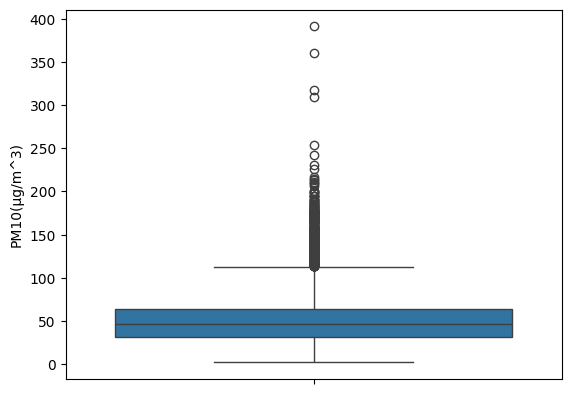

In [ ]:
sns.boxplot(data['PM10(µg/m^3)'])

In [ ]:
#Outlier Detection using IQR
# Calculate the upper and lower limits
Q1 = data['PM10(µg/m^3)'].quantile(0.25)
Q3 = data['PM10(µg/m^3)'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 3*IQR
upper = Q3 + 3*IQR

# Create arrays of Boolean values indicating non outlier rows
data = data[(data['PM10(µg/m^3)'] < upper) & (data['PM10(µg/m^3)'] > lower)]
data

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
0,2021-05-01,01:00:00,25.74,78.63,960.42,3.10,204.53,27.4095,36.3010,46.6625
1,2021-05-01,02:00:00,25.30,81.62,959.98,2.63,205.55,28.5125,37.6835,48.5435
2,2021-05-01,03:00:00,24.86,84.55,959.73,2.03,209.80,33.8070,44.3545,57.4715
3,2021-05-01,04:00:00,24.48,86.96,959.83,1.61,220.12,36.7465,47.5705,62.3160
4,2021-05-01,05:00:00,24.18,88.91,960.10,1.46,239.72,35.2185,45.7880,60.5980
...,...,...,...,...,...,...,...,...,...,...
12749,2023-04-30,19:00:00,26.70,72.89,962.02,1.21,203.39,31.4885,38.2285,47.1120
12750,2023-04-30,20:00:00,25.82,77.90,962.56,1.85,197.49,26.7210,34.3800,41.3970
12751,2023-04-30,21:00:00,25.06,81.28,963.04,2.31,193.28,26.1080,33.5455,40.2245
12752,2023-04-30,22:00:00,24.42,84.06,963.30,2.42,190.59,28.6175,36.9825,45.2260


In [ ]:
data["Time"].apply(lambda x: isinstance(x, datetime.time)).sum()

np.int64(12155)

In [ ]:
data[~data["Time"].apply(lambda x: isinstance(x, datetime.time))]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
23,2021-05-01,"1 day, 0:00:00",25.49,84.29,961.62,3.13,177.55,27.7405,36.7595,46.1270
47,2021-05-02,"1 day, 0:00:00",25.57,78.44,960.98,3.28,201.65,46.7725,59.0010,72.2110
71,2021-05-03,"1 day, 0:00:00",25.06,83.08,961.22,3.81,205.71,27.6375,36.3660,46.3170
95,2021-05-04,"1 day, 0:00:00",25.16,80.55,961.88,3.13,212.56,29.3880,39.4960,51.8805
122,2021-05-06,"1 day, 0:00:00",24.28,90.25,964.38,3.14,222.89,23.4180,30.8685,40.1275
...,...,...,...,...,...,...,...,...,...,...
12634,2023-04-25,"1 day, 0:00:00",24.66,87.72,961.67,1.71,220.21,27.9240,36.0645,43.1840
12658,2023-04-26,"1 day, 0:00:00",24.60,89.84,961.71,2.07,214.08,22.5225,27.9860,32.3760
12682,2023-04-27,"1 day, 0:00:00",23.99,86.37,963.69,1.40,252.66,22.5170,28.5290,33.4825
12706,2023-04-28,"1 day, 0:00:00",24.69,83.90,964.46,0.97,266.39,22.3000,28.5840,34.6775


In [ ]:
data.loc[~data["Time"].apply(lambda x: isinstance(x, datetime.time)), "Time"] = "00:00:00"

In [ ]:
data[~data["Time"].apply(lambda x: isinstance(x, datetime.time))]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
23,2021-05-01,00:00:00,25.49,84.29,961.62,3.13,177.55,27.7405,36.7595,46.1270
47,2021-05-02,00:00:00,25.57,78.44,960.98,3.28,201.65,46.7725,59.0010,72.2110
71,2021-05-03,00:00:00,25.06,83.08,961.22,3.81,205.71,27.6375,36.3660,46.3170
95,2021-05-04,00:00:00,25.16,80.55,961.88,3.13,212.56,29.3880,39.4960,51.8805
122,2021-05-06,00:00:00,24.28,90.25,964.38,3.14,222.89,23.4180,30.8685,40.1275
...,...,...,...,...,...,...,...,...,...,...
12634,2023-04-25,00:00:00,24.66,87.72,961.67,1.71,220.21,27.9240,36.0645,43.1840
12658,2023-04-26,00:00:00,24.60,89.84,961.71,2.07,214.08,22.5225,27.9860,32.3760
12682,2023-04-27,00:00:00,23.99,86.37,963.69,1.40,252.66,22.5170,28.5290,33.4825
12706,2023-04-28,00:00:00,24.69,83.90,964.46,0.97,266.39,22.3000,28.5840,34.6775


In [ ]:
#  Convert DateTime values to time
i = 0
for x in data["Time"] :
  if not isinstance (x, datetime.time):
    data["Time"].iloc[i] = datetime.datetime.strptime(str(x), "%H:%M:%S").time()
  i += 1

In [ ]:
data["Wind direction"].value_counts()

,count
Wind direction,
197.70,6
208.35,6
204.57,5
226.98,5
235.86,5
...,...
219.31,1
271.55,1
273.18,1


In [ ]:
def wind_deg_to_str2(deg):
        arr = ['NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW', 'N']
        return arr[int(abs((float(deg) - 11.25) % 360)/ 22.5)]

In [ ]:
# Feature Engineering

data["DateTime"] = [datetime.datetime.combine(data["Date"].dt.date.iloc[i], data["Time"].iloc[i]) for i in range(len(data))]
data["Year"] =  data["DateTime"].dt.year
data["Month"] = data["DateTime"].dt.month
data["Day"] = data["DateTime"].dt.day
data["Hour"] = data["DateTime"].dt.hour
data["Direction"] = data['Wind direction'].map(wind_deg_to_str2)
encoded_directions = pd.get_dummies(data.Direction, dtype=int)

In [ ]:
data = pd.concat([data, encoded_directions], axis = 1)
data.set_index("DateTime", inplace=True)

In [ ]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12645 entries, 2021-05-01 01:00:00 to 2023-04-30 23:00:00
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            12645 non-null  datetime64[ns]
 1   Time            12645 non-null  object        
 2   Temp(deg)       12645 non-null  float64       
 3   Hum(%)          12645 non-null  float64       
 4   Pre(hPa)        12645 non-null  float64       
 5   WS (m/s)        12645 non-null  float64       
 6   Wind direction  12645 non-null  float64       
 7   PM1(µg/m^3)     12645 non-null  float64       
 8   PM2.5(µg/m^3)   12645 non-null  float64       
 9   PM10(µg/m^3)    12645 non-null  float64       
 10  Year            12645 non-null  int32         
 11  Month           12645 non-null  int32         
 12  Day             12645 non-null  int32         
 13  Hour            12645 non-null  int32         
 14  Direction       126

In [ ]:
data["Direction"].value_counts()

,count
Direction,
SW,1773
SSW,1691
NE,1336
WSW,1228
S,1077
SSE,834
W,708
SE,647
ESE,621


<Figure size 2500x1000 with 0 Axes>

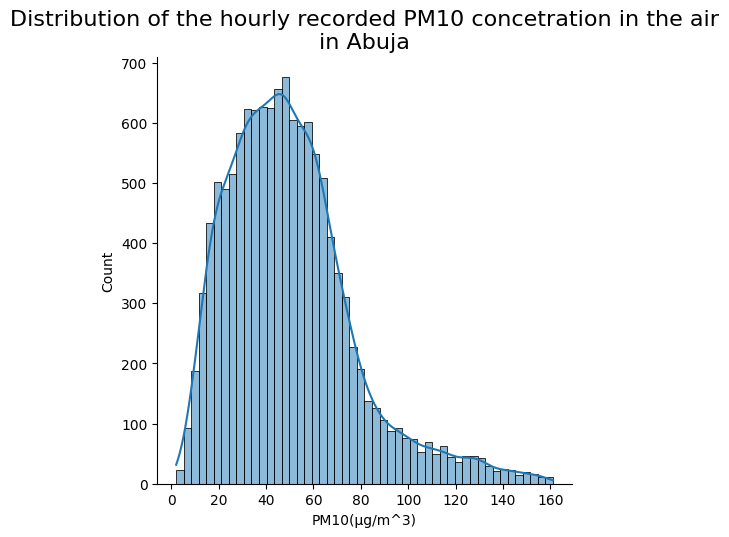

In [ ]:
plt.figure(figsize=(25,10))
sns.displot(data['PM10(µg/m^3)'],bins=50, kde=True , lw=5)
plt.title('Distribution of the hourly recorded PM10 concetration in the air\nin Abuja',
          fontsize=16)
plt.show();

In [ ]:
# find the daily average of PM10 contained in the air in any given hour
monthly_data = data[['PM10(µg/m^3)']]
monthly_data = monthly_data.resample('M').median()

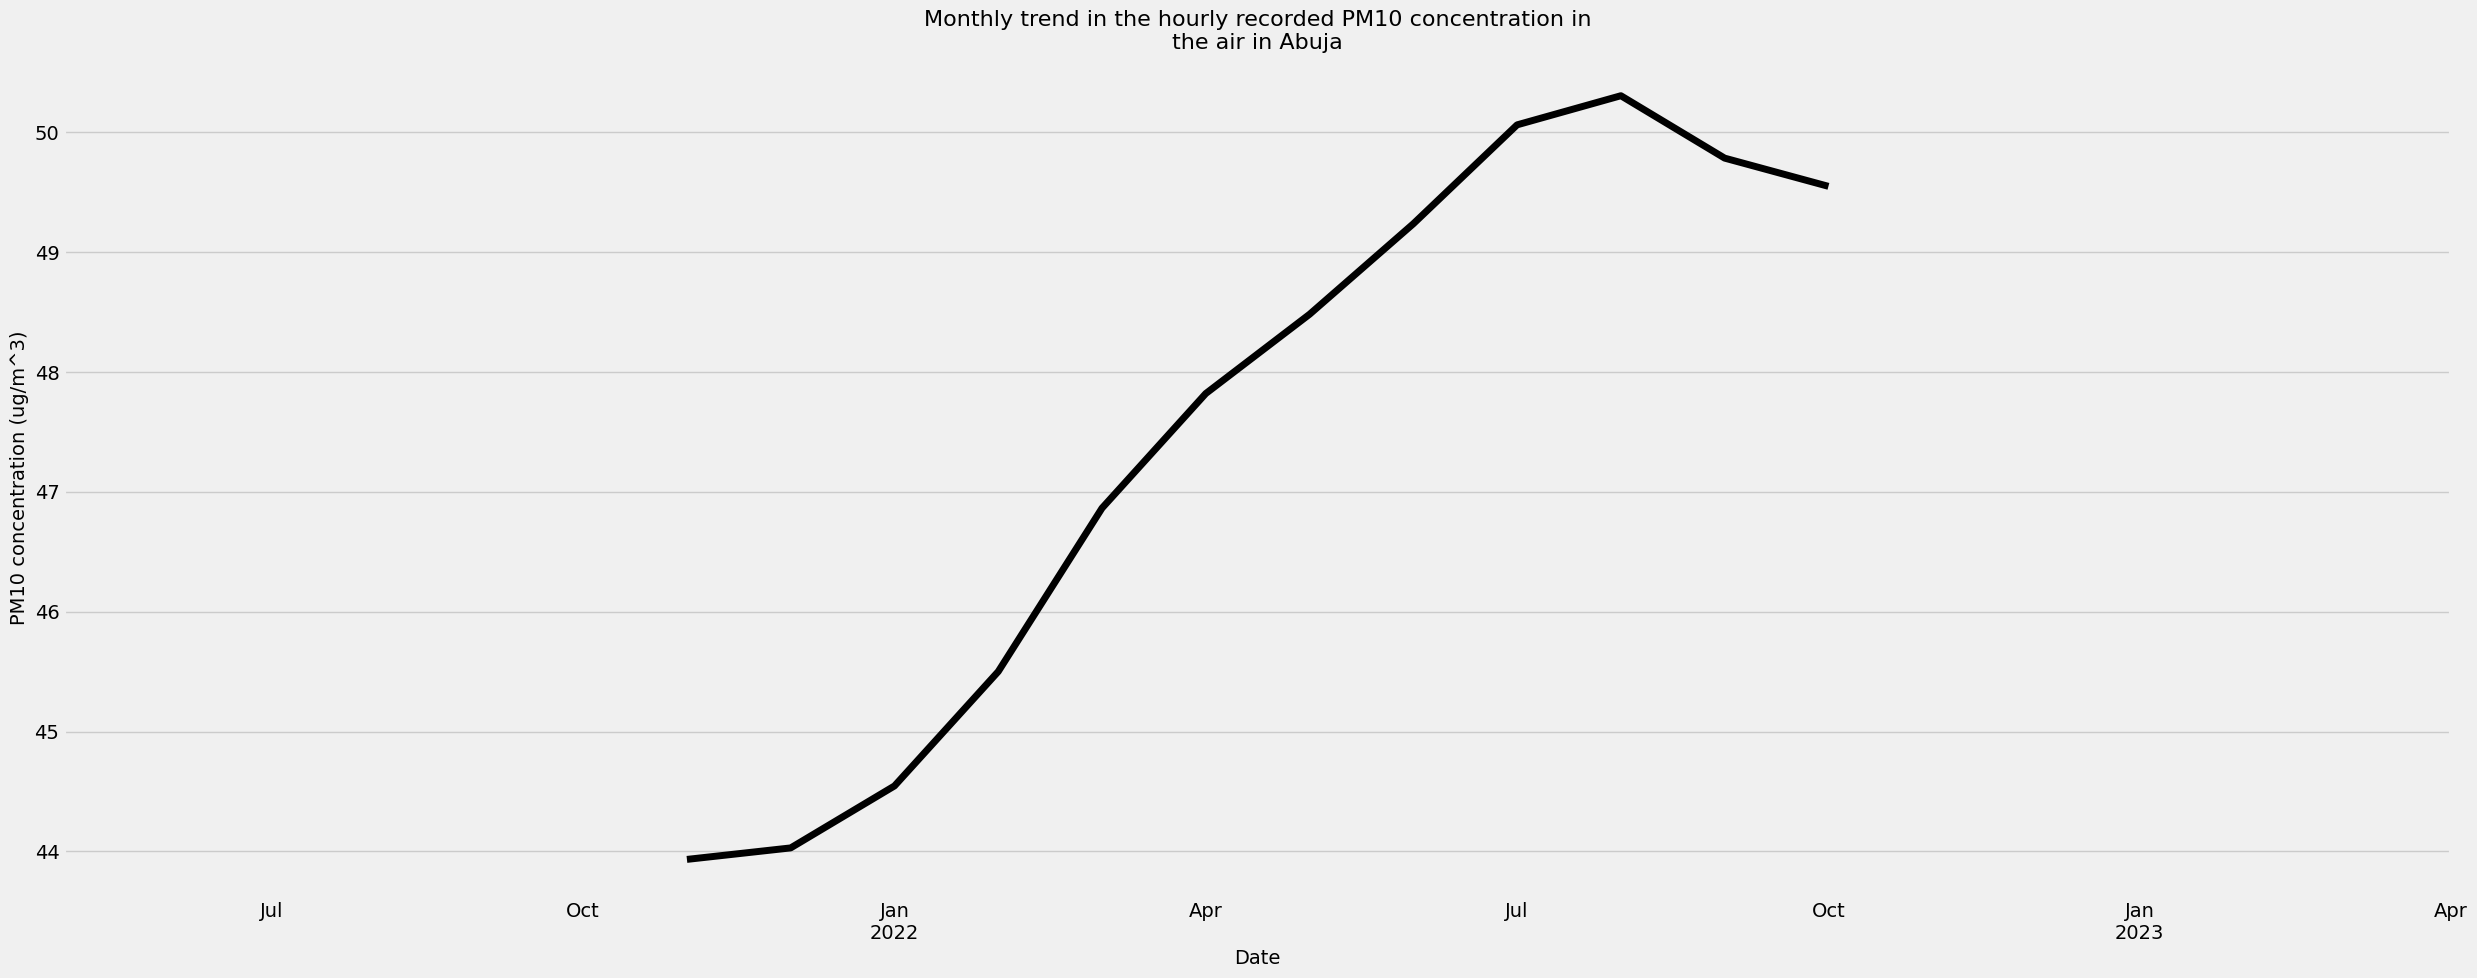

In [ ]:
decomposition = seasonal_decompose(monthly_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(25,10),style='k-',linewidth=5,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly trend in the hourly recorded PM10 concentration in\nthe air in Abuja',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

In [ ]:
daily_data = data[['PM10(µg/m^3)']]
daily_data = daily_data.resample('D').median()

In [ ]:
daily_data.interpolate(inplace=True)

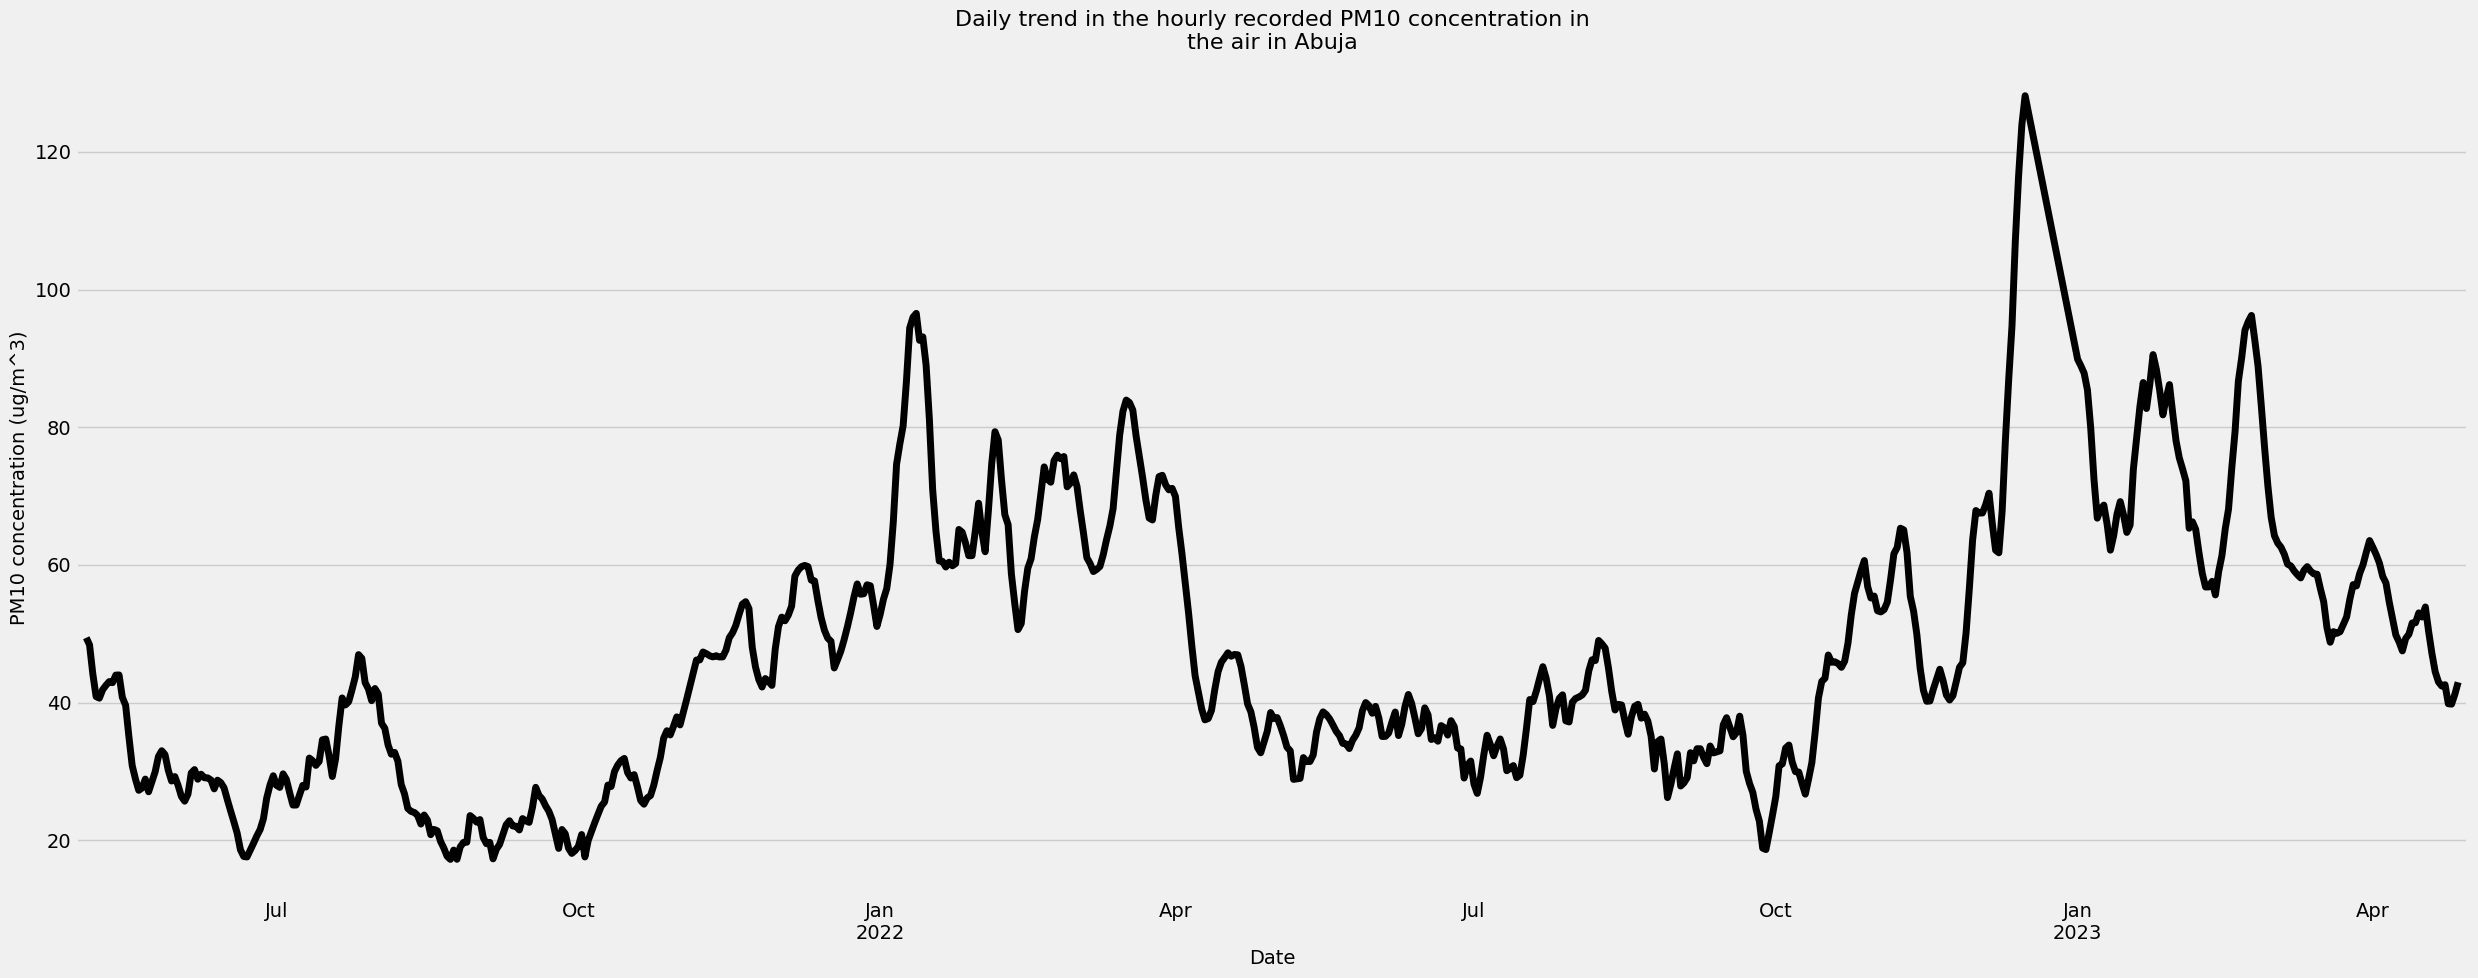

In [ ]:
decomposition = seasonal_decompose(daily_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(25,10),style='k-',linewidth=5,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Daily trend in the hourly recorded PM10 concentration in\nthe air in Abuja',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

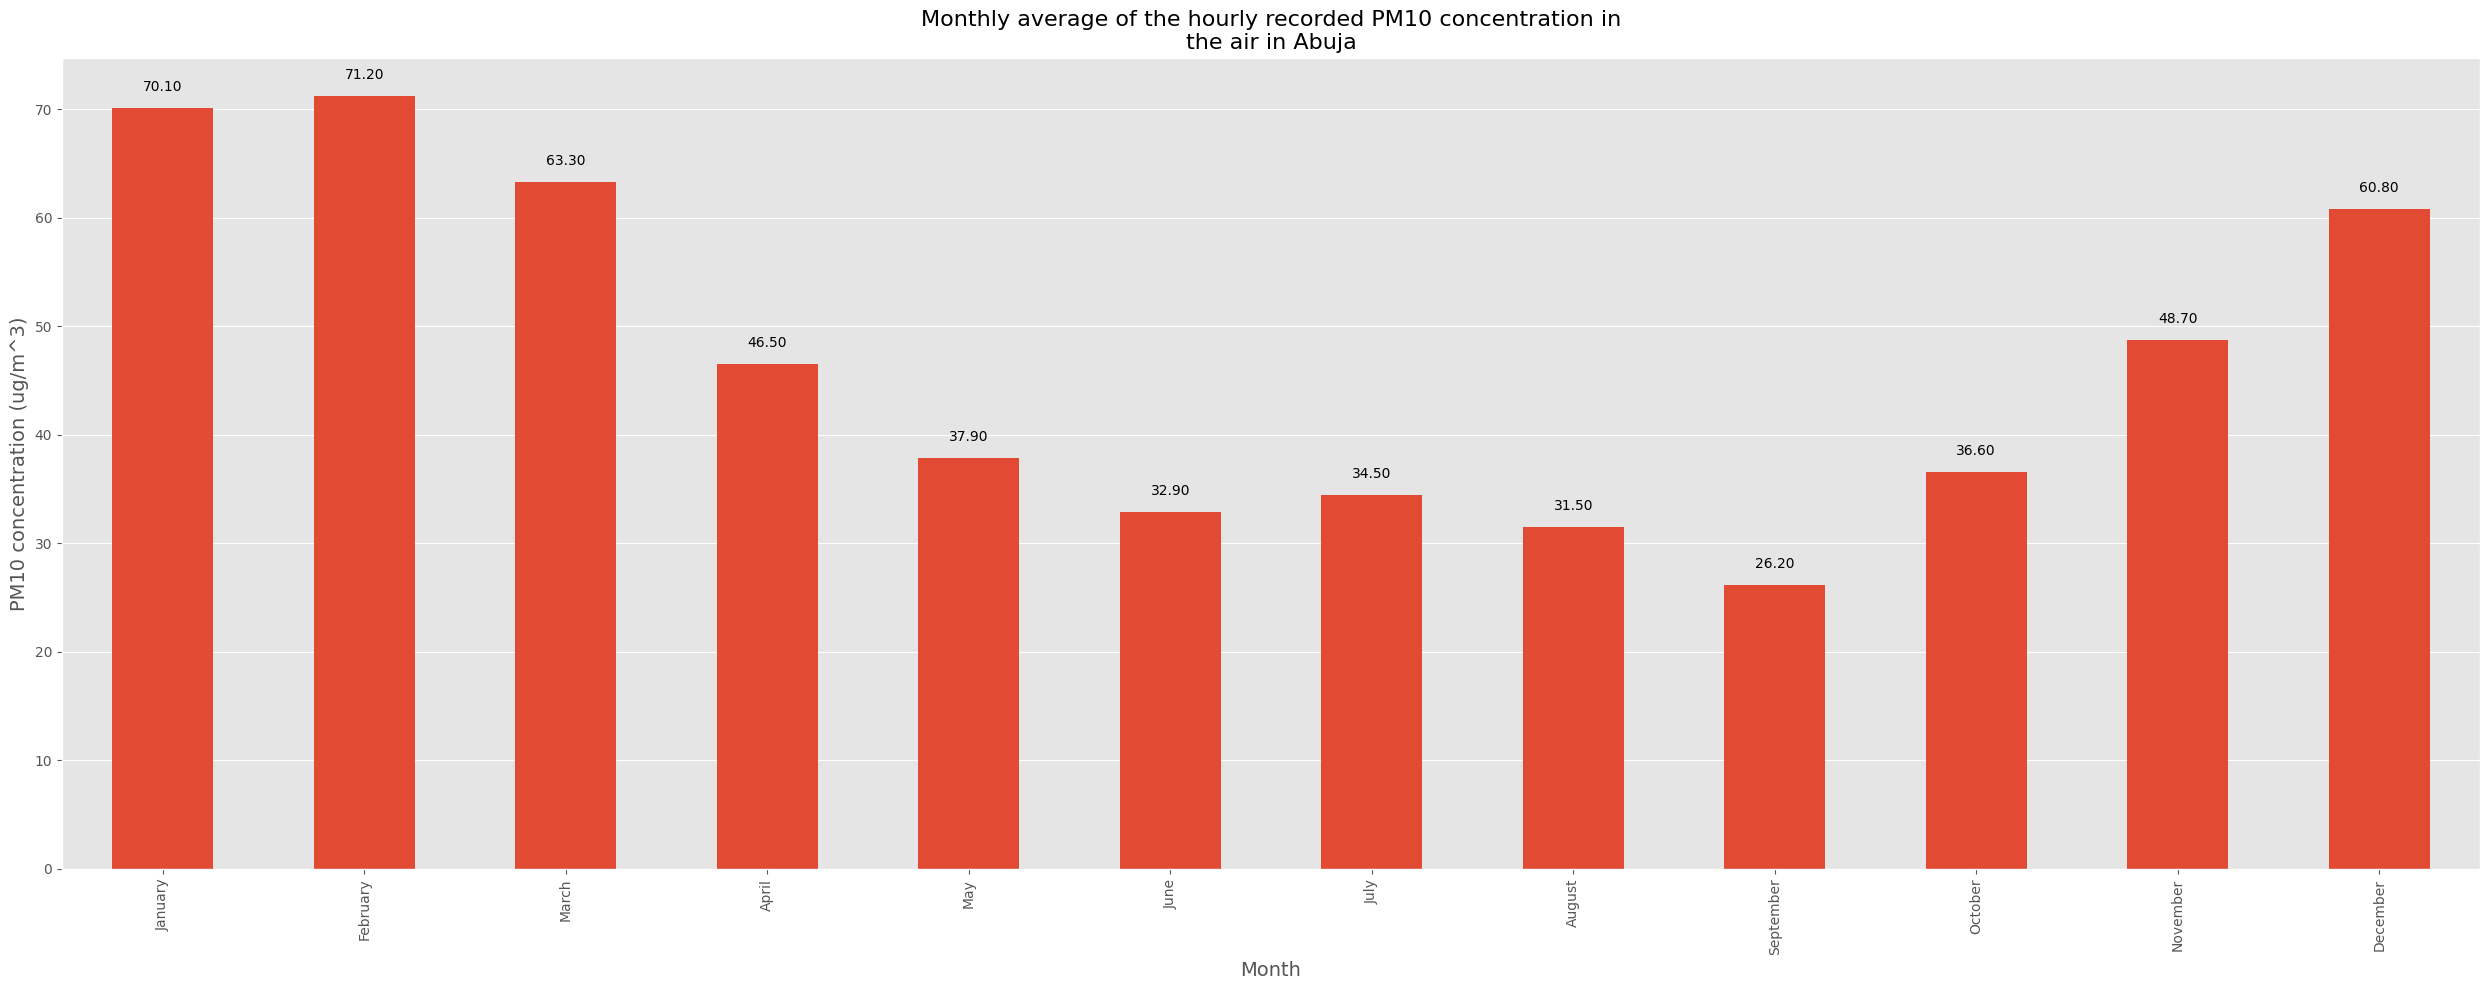

In [ ]:
monthly_data = data[['Month','PM10(µg/m^3)']]
month = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(month,columns=['month'])
map_dict = {}
for i,j in enumerate(month):
    map_dict.setdefault(i+1,j)

monthly_data.Month = monthly_data.Month.map(map_dict)
monthly_average = monthly_data.groupby('Month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(25,10),legend=False,kind='bar',linewidth=5)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM10 concentration in\nthe air in Abuja',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

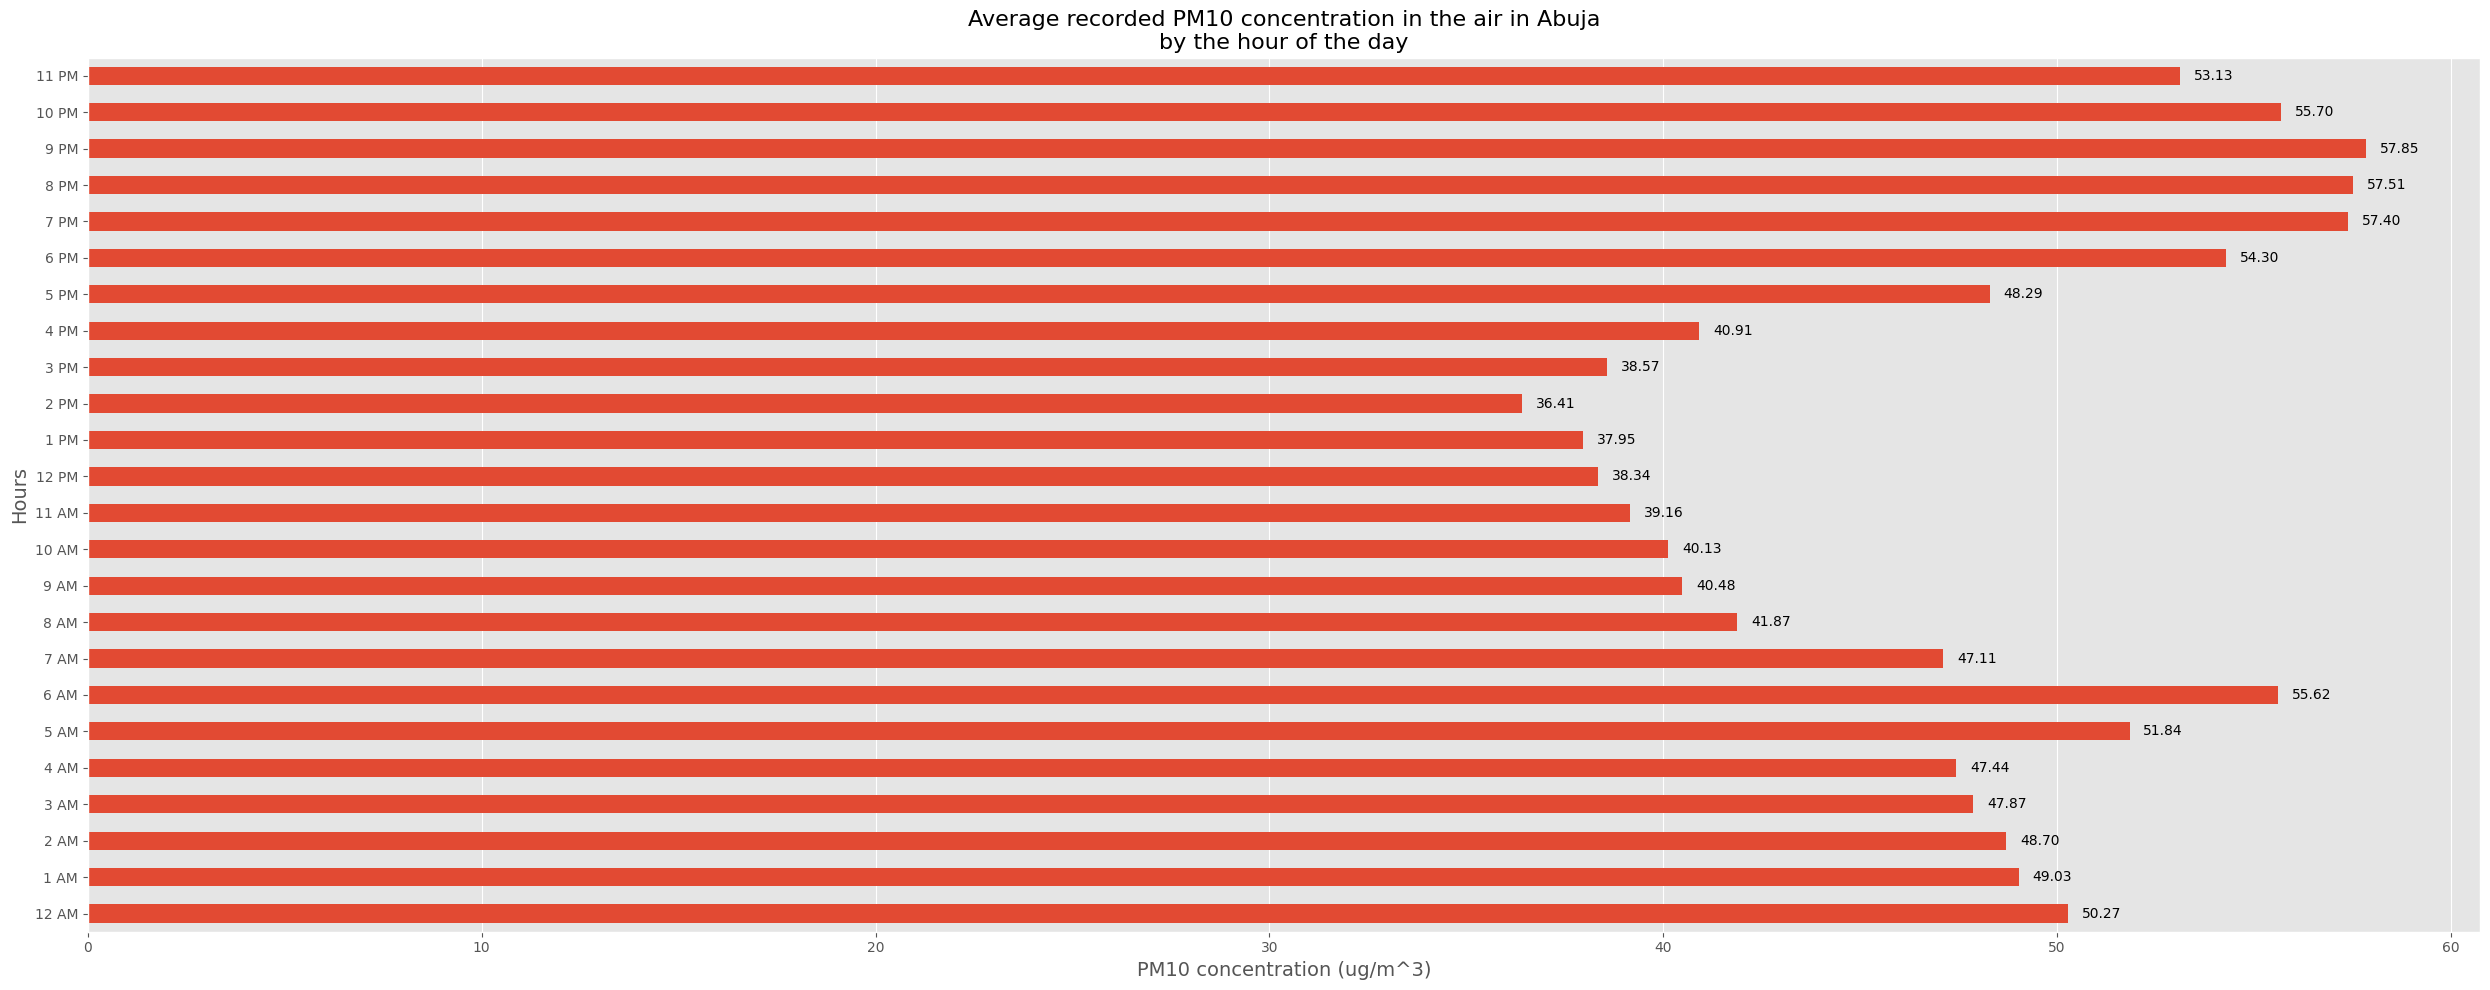

In [ ]:
hourly_data = data[['Hour','PM10(µg/m^3)']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)

hourly_data = hourly_data.groupby('Hour').median().reset_index()
hourly_data.Hour = hourly_data.Hour.map(hour_dict)
hourly_data = hourly_data.set_index('Hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(25,10),legend=False,kind='barh',linewidth=5)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM10 concentration in the air in Abuja\nby the hour of the day',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show();

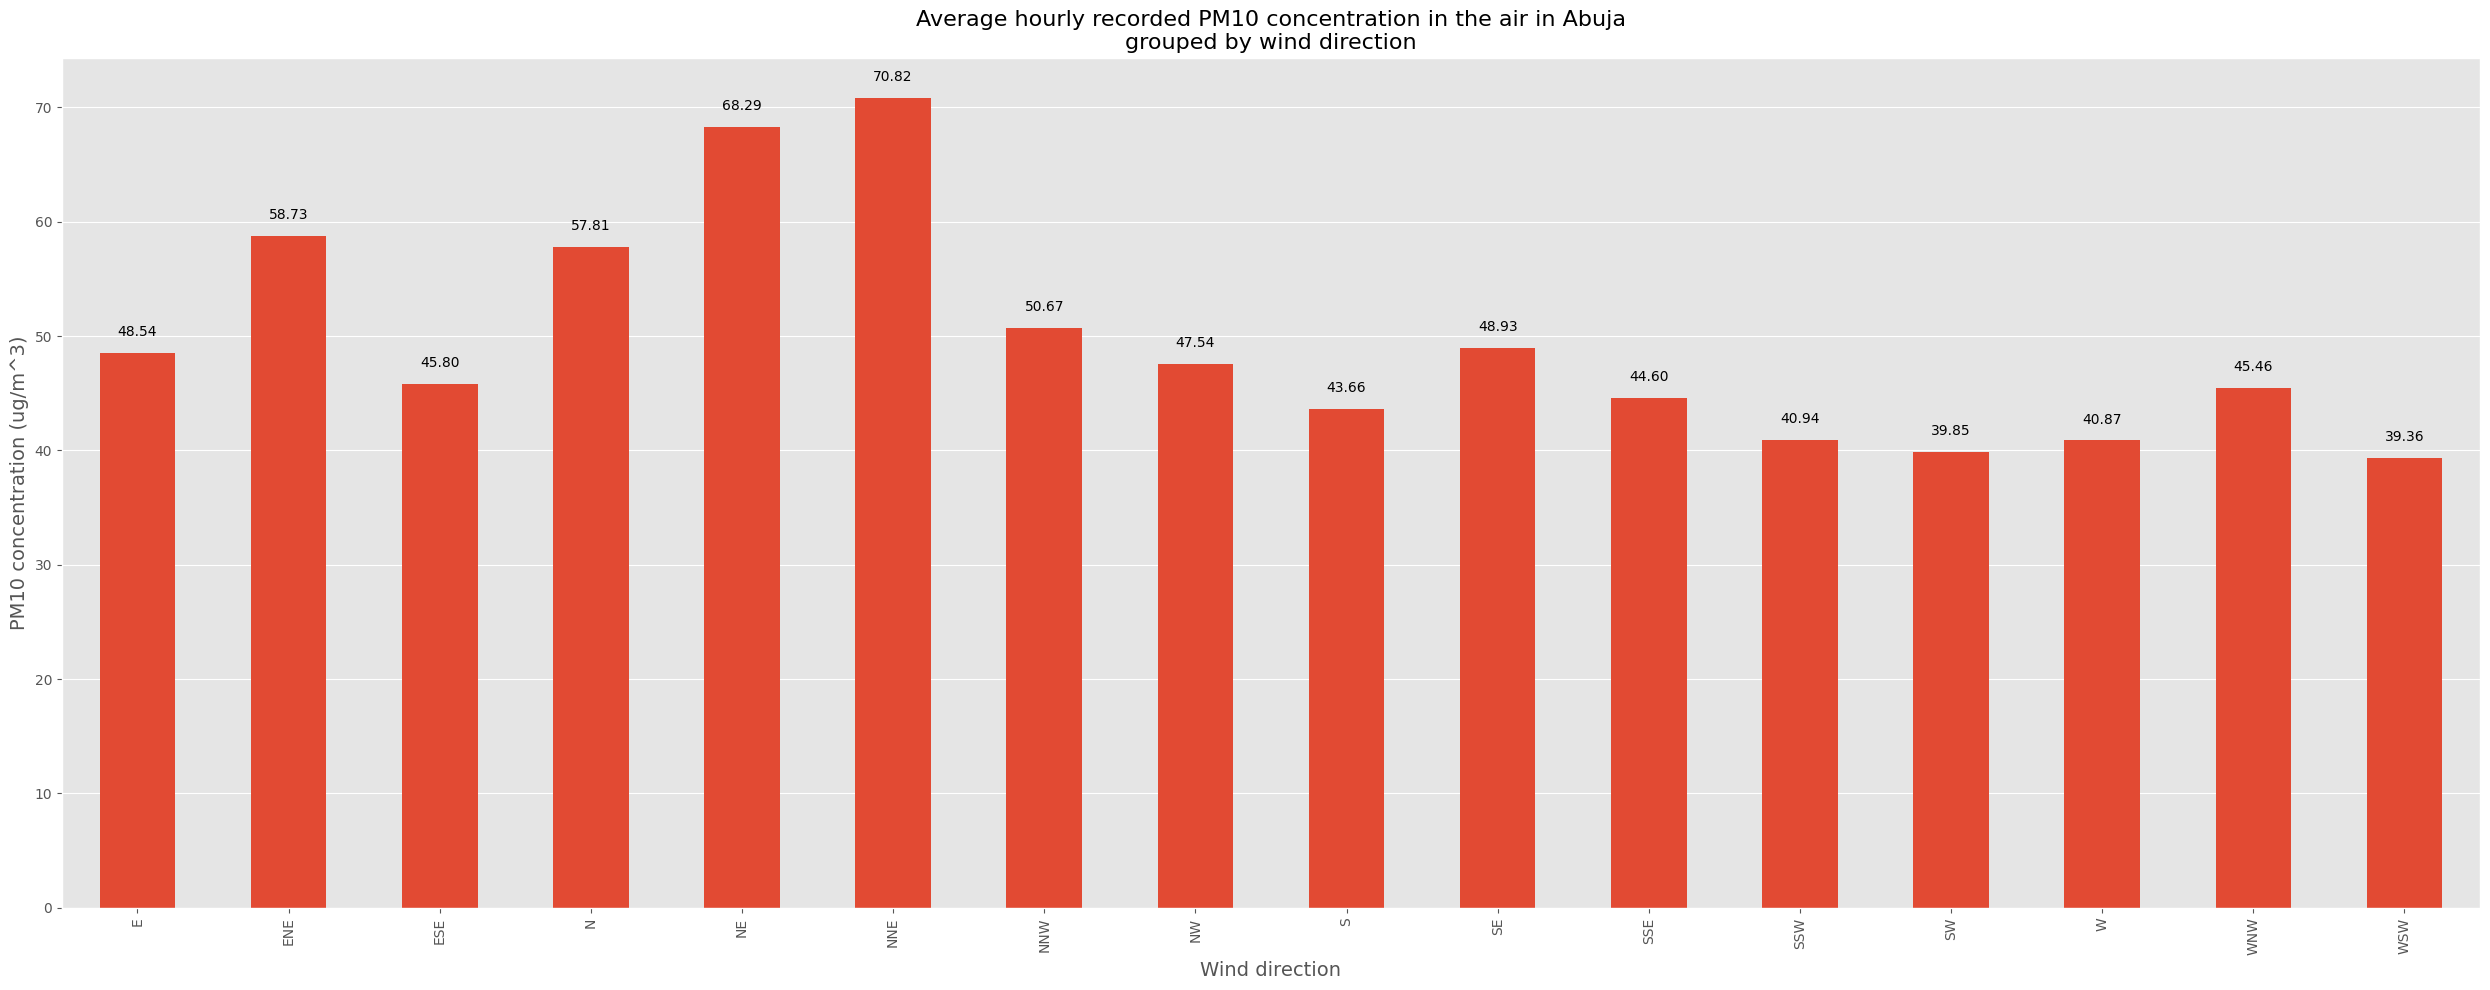

In [ ]:
wind_dir = data[['Direction','PM10(µg/m^3)']]
wind_dir = wind_dir.groupby('Direction').median()

# plot the data
with plt.style.context('ggplot'):
    wind_dir.plot(figsize=(25,10),legend=False,kind='bar',linewidth=5)
    plt.xlabel('Wind direction',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Average hourly recorded PM10 concentration in the air in Abuja\ngrouped by wind direction',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

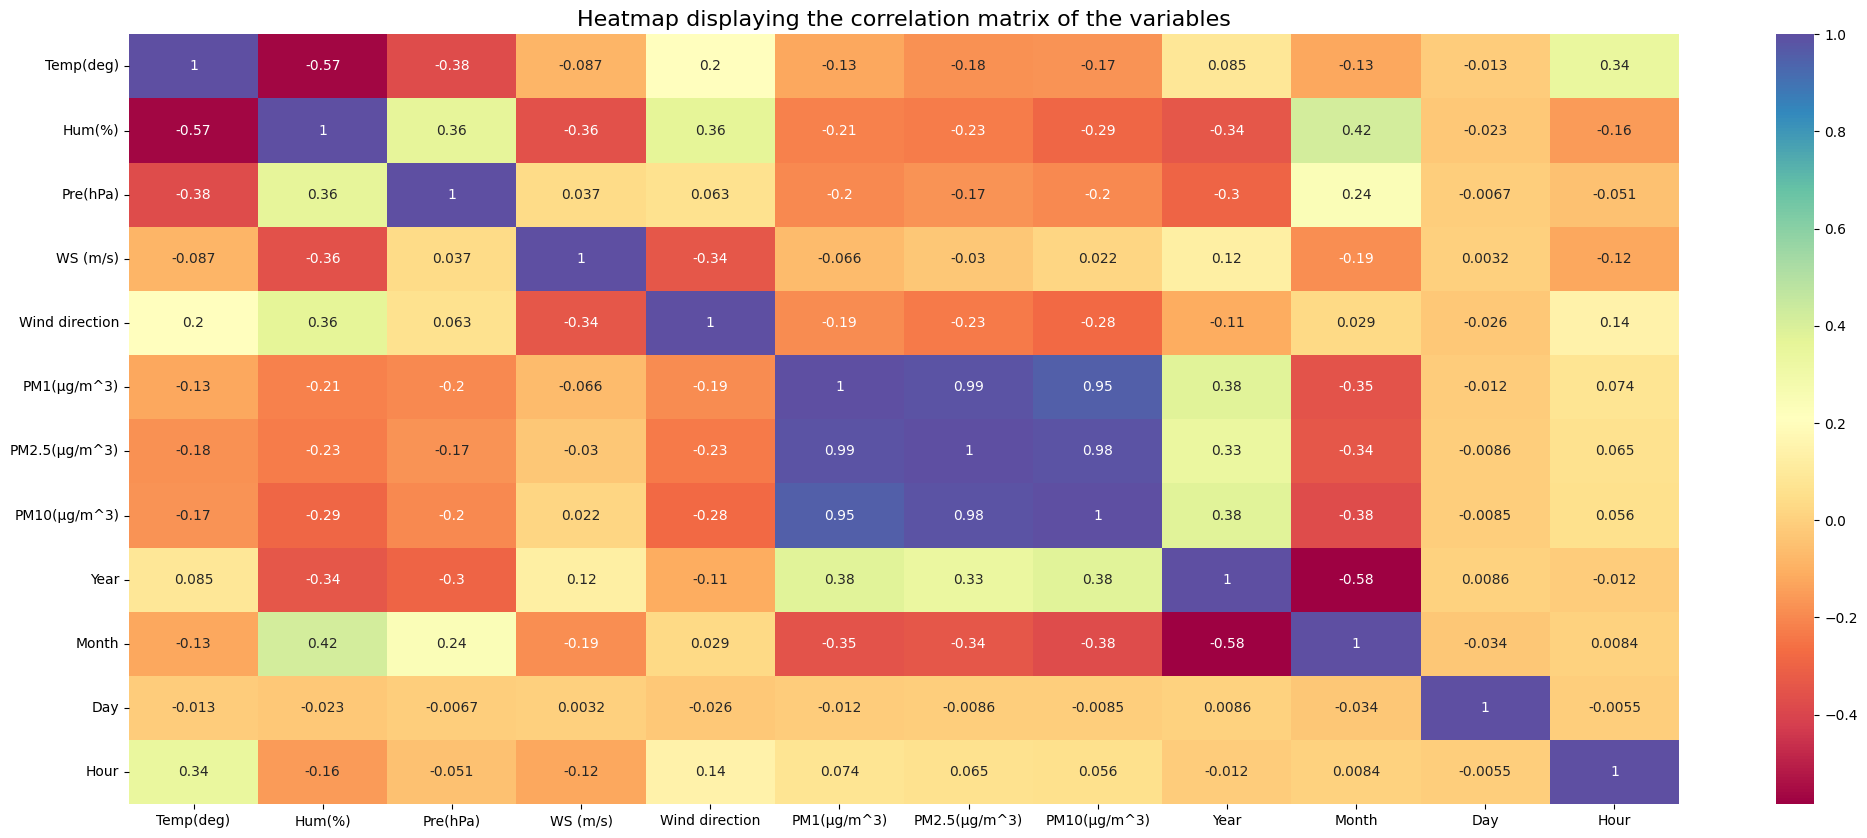

In [ ]:
# Visualize the relationships between the features of the data
plt.figure(figsize=(25,10))
correlation_data = data[['Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)',
       'Wind direction', 'PM1(µg/m^3)','PM2.5(µg/m^3)', 'PM10(µg/m^3)',
       'Year', 'Month', 'Day', 'Hour',]]
sns.heatmap(correlation_data.corr(),annot = True,cmap="Spectral",)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16);

Model Training and Evaluation

In [ ]:
data.columns

Index(['Date', 'Time', 'Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)',
       'Wind direction', 'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)',
       'Year', 'Month', 'Day', 'Hour', 'Direction', 'E', 'ENE', 'ESE', 'N',
       'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW',
       'WSW'],
      dtype='object')

In [ ]:
cols_to_drop = ['Date', 'Time', 'Direction' , 'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)']
X = data.drop(cols_to_drop,axis=1)
y= data['PM10(µg/m^3)']

In [ ]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [ ]:
# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled = preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns, index=X.index)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,Year,Month,Day,Hour,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-01 01:00:00,0.119192,0.394796,-1.426308,0.505139,0.333080,-1.295103,-0.319265,-1.620643,-1.576562,-0.213447,-0.223579,-0.227259,-0.128689,-0.343709,-0.16139,-0.136712,-0.160096,-0.305126,-0.232219,-0.265729,2.545157,-0.403831,-0.243539,-0.203324,-0.327962
2021-05-01 02:00:00,0.016959,0.532433,-1.655529,0.137166,0.345266,-1.295103,-0.319265,-1.620643,-1.428760,-0.213447,-0.223579,-0.227259,-0.128689,-0.343709,-0.16139,-0.136712,-0.160096,-0.305126,-0.232219,-0.265729,2.545157,-0.403831,-0.243539,-0.203324,-0.327962
2021-05-01 03:00:00,-0.085274,0.667309,-1.785768,-0.332586,0.396038,-1.295103,-0.319265,-1.620643,-1.280957,-0.213447,-0.223579,-0.227259,-0.128689,-0.343709,-0.16139,-0.136712,-0.160096,-0.305126,-0.232219,-0.265729,2.545157,-0.403831,-0.243539,-0.203324,-0.327962
2021-05-01 04:00:00,-0.173567,0.778247,-1.733673,-0.661413,0.519325,-1.295103,-0.319265,-1.620643,-1.133154,-0.213447,-0.223579,-0.227259,-0.128689,-0.343709,-0.16139,-0.136712,-0.160096,-0.305126,-0.232219,-0.265729,-0.392903,2.476283,-0.243539,-0.203324,-0.327962
2021-05-01 05:00:00,-0.243272,0.868010,-1.593014,-0.778851,0.753476,-1.295103,-0.319265,-1.620643,-0.985351,-0.213447,-0.223579,-0.227259,-0.128689,-0.343709,-0.16139,-0.136712,-0.160096,-0.305126,-0.232219,-0.265729,-0.392903,-0.403831,-0.243539,-0.203324,3.049136


In [ ]:
# we now split out data into train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=53)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=53)

In [ ]:
# instantiate the linear regression model
lin_model = LinearRegression()

# Fitting the model
lin_model.fit(X_train,y_train)

# Model Performance on the validation data
linear_reg_perf_test = model_performance_regression(lin_model, X_val, y_val)
linear_reg_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,20.457151,15.623024,0.430704,0.419217,42.399708


In [ ]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 53)

# Fitting the model
rf_regression = rf_regressor.fit(X_train, y_train)

# Model Performance on the validation data
rf_regressor_perf_test = model_performance_regression(rf_regressor, X_val, y_val)
rf_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,13.297053,9.387219,0.759476,0.754623,24.499978


In [ ]:
# Support Vector Machine Regression
random_state=53
svr = SVR(kernel ='linear').fit(X_train, y_train)

# Model Performance on the validation data
svr_regressor_perf_test = model_performance_regression(svr, X_val, y_val)
svr_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,20.586407,15.544384,0.423487,0.411855,40.876182


In [ ]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features=None,
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(X_train,y_train)

# Model Performance on the validation data
grad_boost_perf_test = model_performance_regression(grad_boost, X_val, y_val)
grad_boost_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,13.989562,10.246831,0.733771,0.728399,27.224261


In [ ]:
#Model performance comparison

models_test_comp_df = pd.concat(
    [
        linear_reg_perf_test.T,
        rf_regressor_perf_test.T,
        svr_regressor_perf_test.T,
        grad_boost_perf_test.T,
        ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Multiple Linear Regression",
    "Random Forest ",
    "Support Vector Machine",
    "Gradient Boosting",
    ]

print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Multiple Linear Regression,20.457151,15.623024,0.430704,0.419217,42.399708
Random Forest,13.297053,9.387219,0.759476,0.754623,24.499978
Support Vector Machine,20.586407,15.544384,0.423487,0.411855,40.876182
Gradient Boosting,13.989562,10.246831,0.733771,0.728399,27.224261


In [ ]:
# Melt the DataFrame to long format for Seaborn
df_melted = pd.melt(models_test_comp_df, var_name='Model', value_name='Value', ignore_index = False)
df_melted.reset_index(inplace=True)
df_melted

,index,Model,Value
0,RMSE,Multiple Linear Regression,20.457151
1,MAE,Multiple Linear Regression,15.623024
2,R-squared,Multiple Linear Regression,0.430704
3,Adj. R-squared,Multiple Linear Regression,0.419217
4,MAPE,Multiple Linear Regression,42.399708
5,RMSE,Random Forest,13.297053
6,MAE,Random Forest,9.387219
7,R-squared,Random Forest,0.759476
8,Adj. R-squared,Random Forest,0.754623
9,MAPE,Random Forest,24.499978


In [ ]:
def plot_model_comparison(df_melted):
  """
  Generates a bar chart for model comparison.

  Args:
    df_melted: A pandas DataFrame in melted format, containing the model performance metrics.

  Returns:
    None. Displays the bar chart.
  """

  # Create a list of subplots
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 10))

  # Loop through each index value and create a bar chart for each
  for i, index in enumerate(df_melted['index'].unique()):
      # Filter the data for the current index value
      data = df_melted[df_melted['index'] == index]

      # Create a bar chart
      axes[i].bar(data['Model'], data['Value'])
      axes[i].set_title(index)
      axes[i].tick_params(axis='x', labelrotation=90)
      axes[i].bar_label(axes[i].containers[0], fmt='%.2f', padding=12)

  plt.show()  # Display the chart

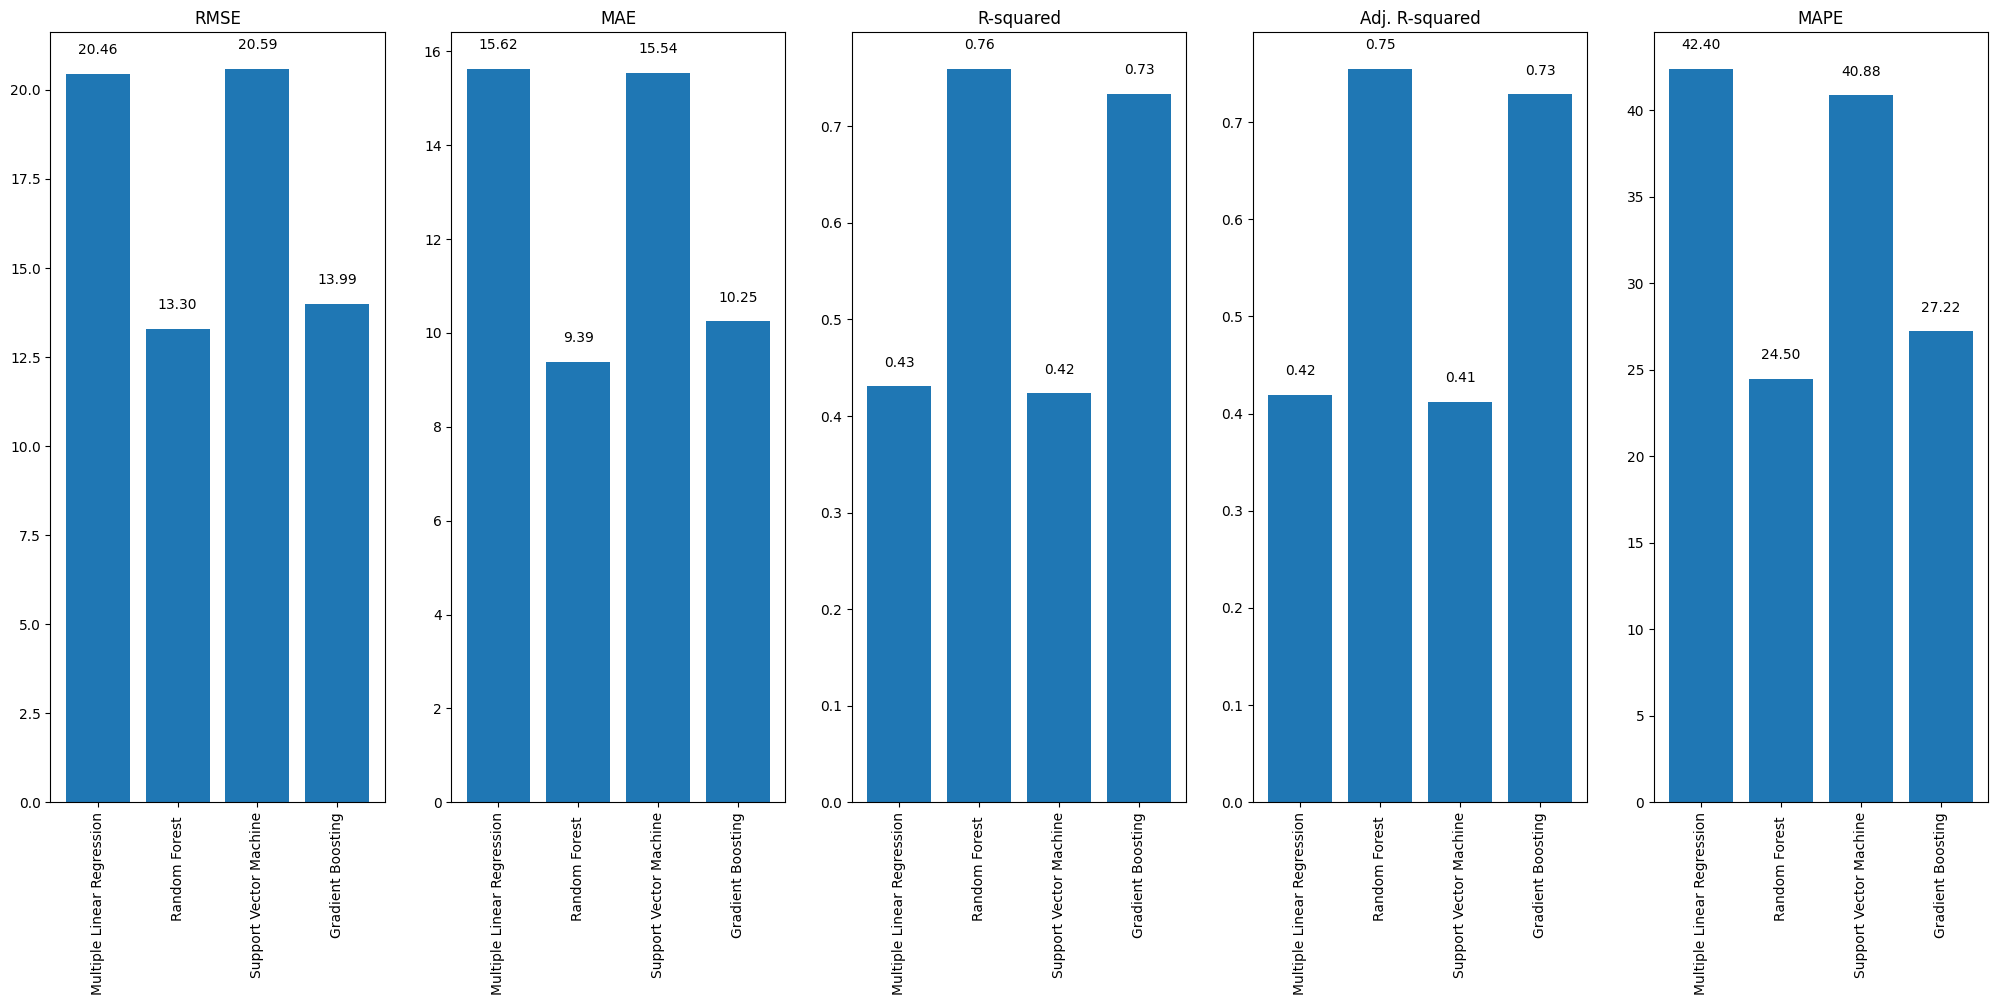

In [ ]:
plot_model_comparison(df_melted)

In [ ]:
#Hyperparameter tunning for Random Forest

# Define the hyperparameter search space
param_dist = {
    'n_estimators': np.arange(50, 501, 50),  # Expanded range
    'max_depth': [None, 5, 10, 20],  # Added values
    'min_samples_split': np.arange(2, 11, 2),  # Expanded range
    'min_samples_leaf': np.arange(1, 5, 1),  # Added values
    'max_features': [None, 'sqrt', 'log2'],  # Added options
    'bootstrap': [True, False],  # Added option
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Evaluation metric
    random_state=53,  # For reproducibility
    n_jobs=-1,  # Use all available cores for parallel processing
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

In [ ]:
best_params = {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': True}
# Random Forest Regressor
best_model = RandomForestRegressor(**best_params)

# Fitting the model
best_model = best_model.fit(X_train, y_train)

# Evaluate the tuned random forest model on the validation data
RF_tuned_model =  model_performance_regression(best_model, X_val, y_val)
RF_tuned_model

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,13.2921,9.340376,0.759655,0.754806,24.407628


In [ ]:
#Fine tuned model performance comparison

models_test_comp_df = pd.concat(
    [
        rf_regressor_perf_test.T,
        RF_tuned_model.T,
        ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Random Forest ",
    "Fine-tuned Random Forest",
    ]


print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Random Forest,13.297053,9.387219,0.759476,0.754623,24.499978
Fine-tuned Random Forest,13.292100,9.340376,0.759655,0.754806,24.407628


In [ ]:
# Melt the DataFrame to long format for Seaborn
df_melted = pd.melt(models_test_comp_df, var_name='Model', value_name='Value', ignore_index = False)
df_melted.reset_index(inplace=True)
df_melted

,index,Model,Value
0,RMSE,Random Forest,13.297053
1,MAE,Random Forest,9.387219
2,R-squared,Random Forest,0.759476
3,Adj. R-squared,Random Forest,0.754623
4,MAPE,Random Forest,24.499978
5,RMSE,Fine-tuned Random Forest,13.292100
6,MAE,Fine-tuned Random Forest,9.340376
7,R-squared,Fine-tuned Random Forest,0.759655
8,Adj. R-squared,Fine-tuned Random Forest,0.754806
9,MAPE,Fine-tuned Random Forest,24.407628


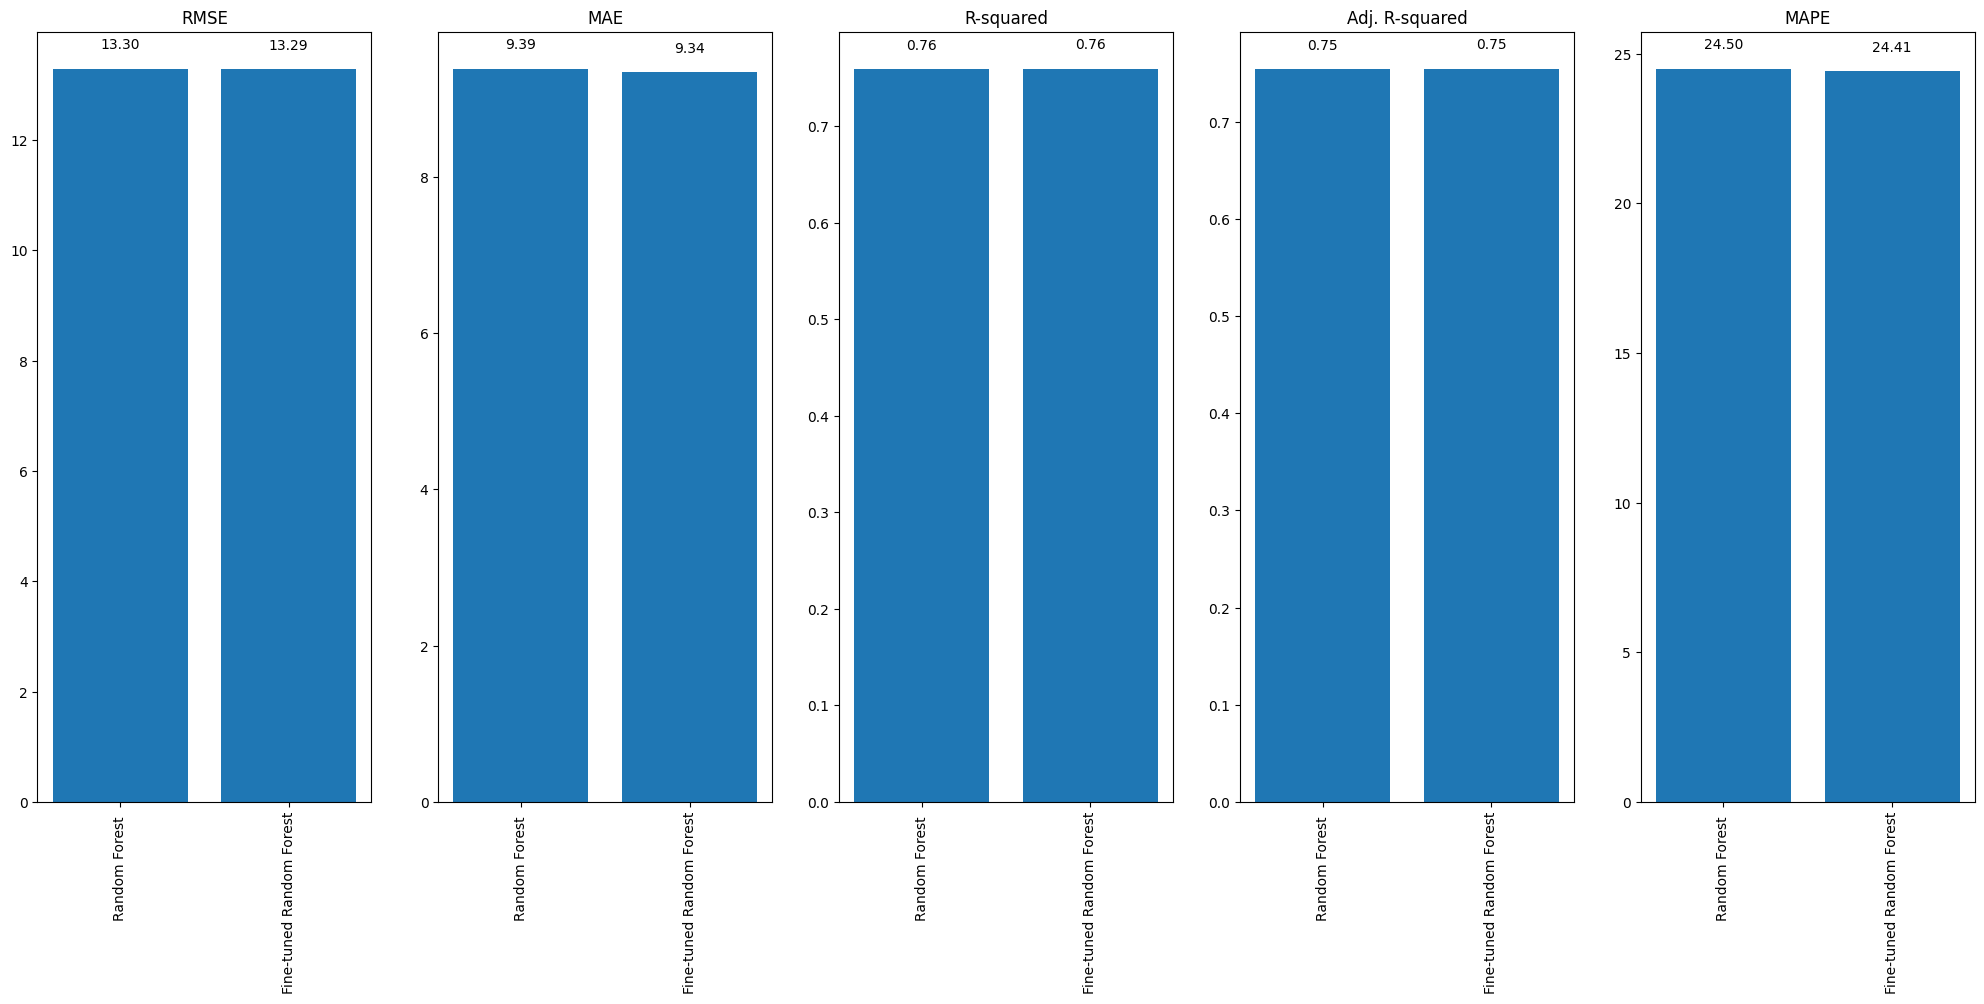

In [ ]:
plot_model_comparison(df_melted)

In [ ]:
# Evaluate the best model on the test data
RF_tuned_model =  model_performance_regression(best_model, X_test, y_test)
RF_tuned_model

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,13.215832,9.357891,0.765529,0.760794,25.272016


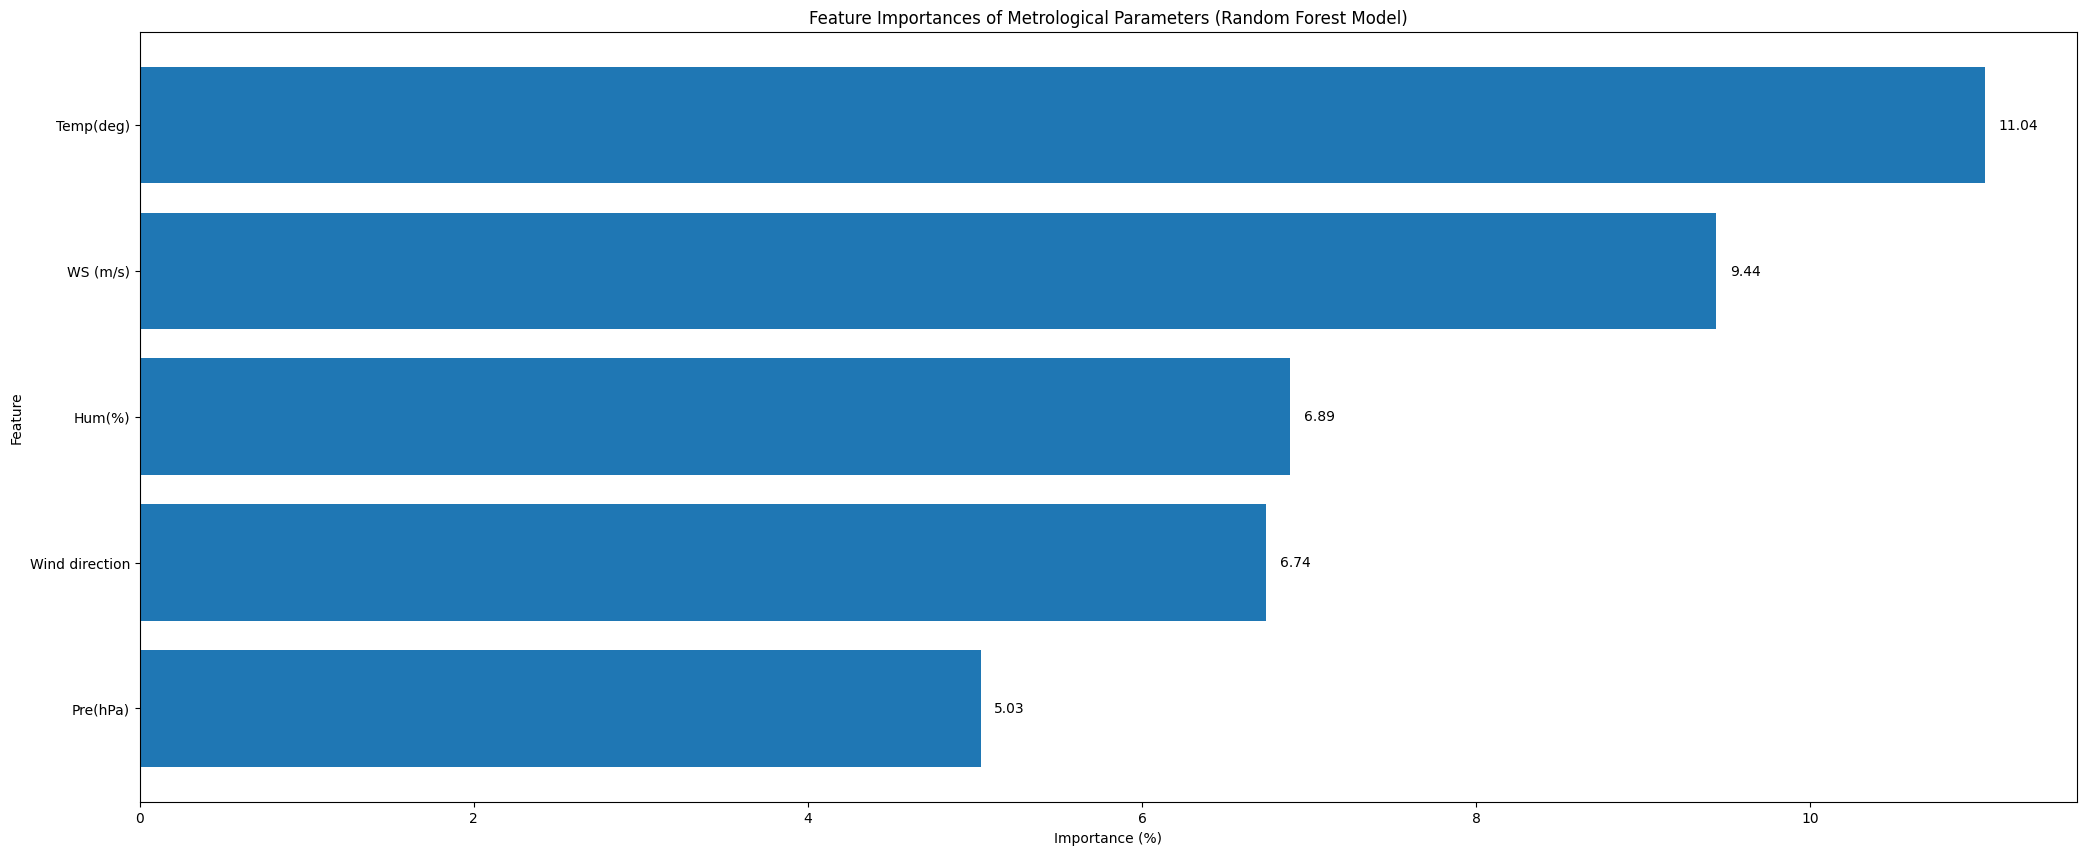

In [ ]:
# Feature importance of the best model (Random Forest model)
# Get feature importances
importances = best_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort importances and feature names
importances, feature_names = zip(*sorted(zip(importances*100, feature_names)))

#Keep only Metrological Features
features_to_keep = ['Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)','Wind direction']

importance =  [importance for importance, feature_name in zip(importances, feature_names) if feature_name in features_to_keep]
feature_names = [name for name in feature_names if name in features_to_keep]

# Create a vertical bar chart
plt.figure(figsize=(25, 10))
plt.barh(feature_names, importance)

# Show plot

# Get the current Axes object
ax = plt.gca()
# Add value labels on top of bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=10)

# Set title and axis labels
plt.title("Feature Importances of Metrological Parameters (Random Forest Model)")
plt.xlabel("Importance (%)")
plt.ylabel("Feature")

# Show the plot
plt.show();

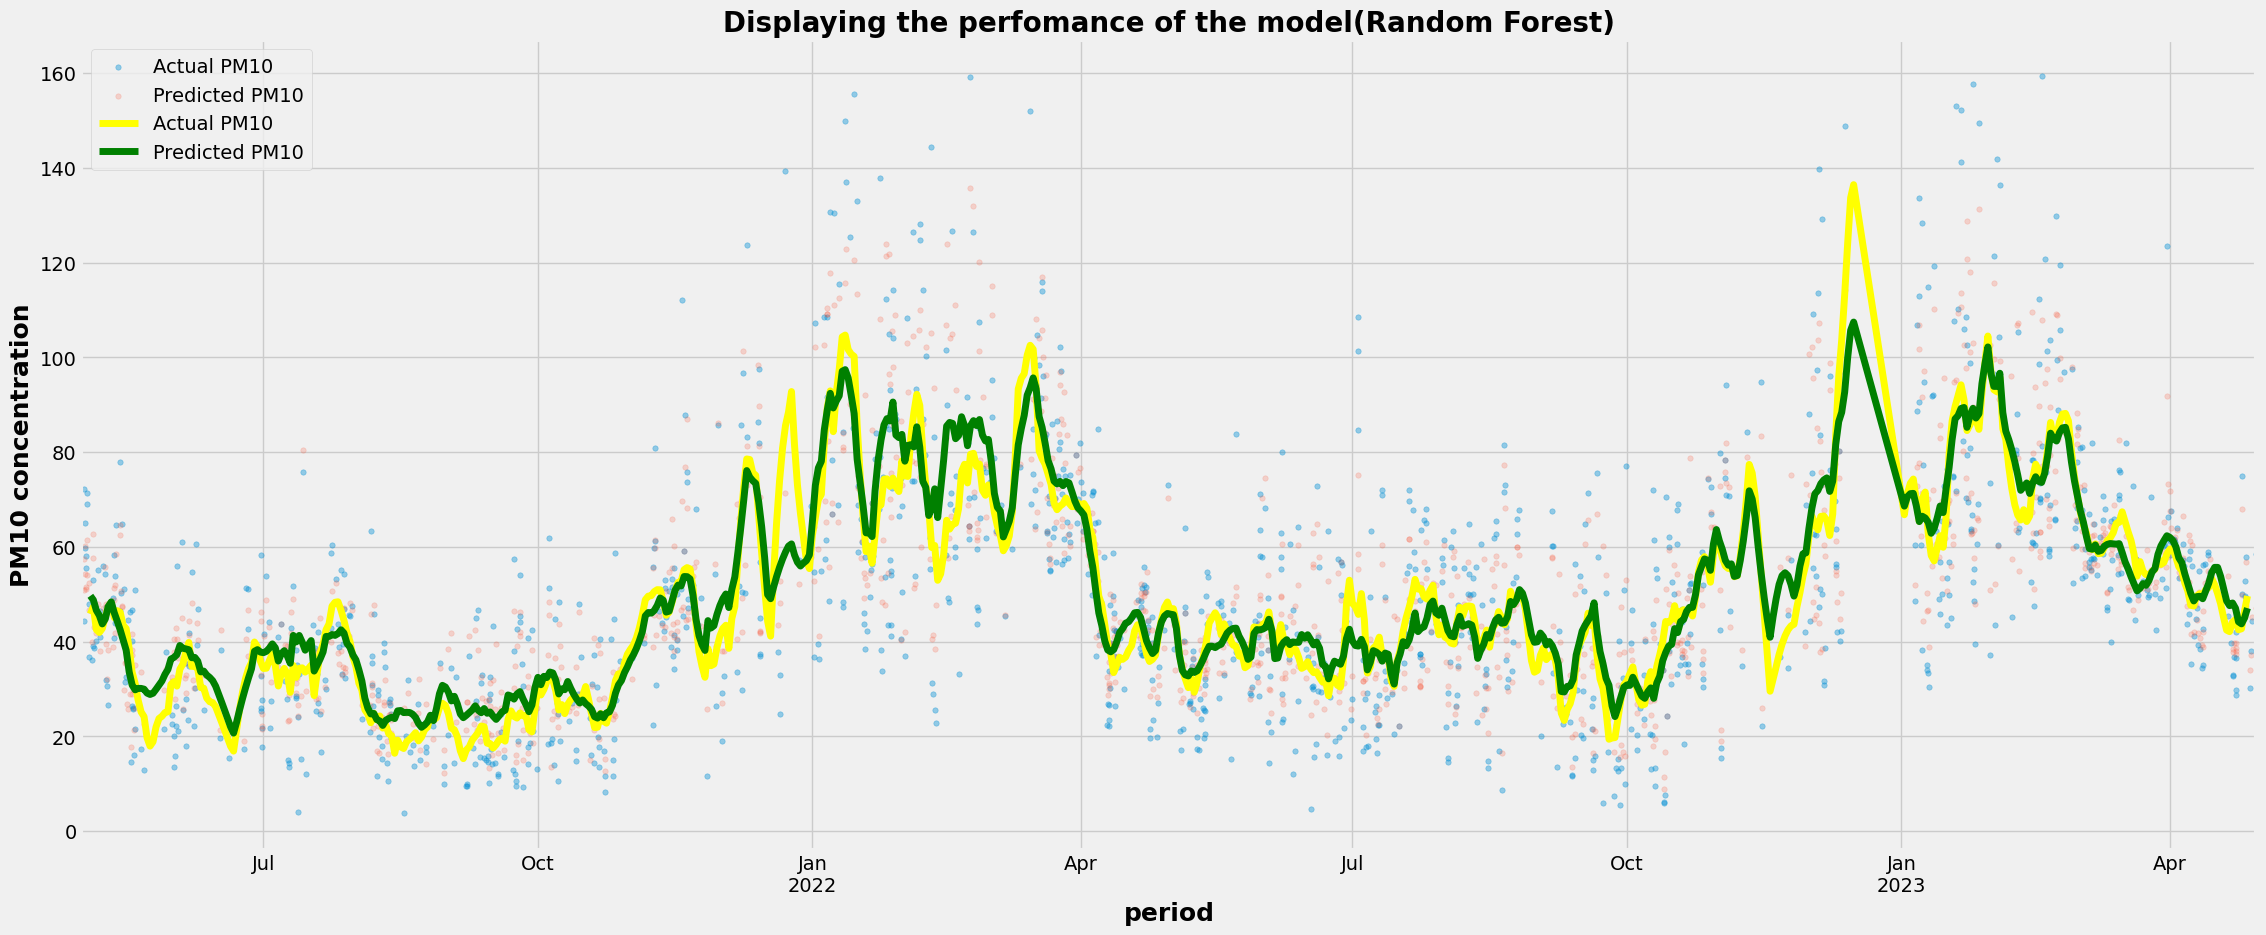

In [ ]:
# we now use the best model (Random forest model) to predict the PM10
# concetration and compare it to the actual PM10 recorded in the data by means of
# visualization

compare_data = pd.DataFrame({'Actual PM10':y_test,
                            'Predicted PM10':best_model.predict(X_test.values)})
colors = {
    "Actual PM10": "yellow",
    "Predicted PM10": "green",
}

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(25,10))
    plt.scatter(compare_data.index,compare_data['Actual PM10'],s=15,label='Actual PM10',
               alpha=.4)
    plt.scatter(compare_data.index,compare_data['Predicted PM10'],s=15,label='Predicted PM10',
               alpha=.2)

    compare_daily_data = compare_data.resample('D').median()
    compare_daily_data.interpolate(inplace=True)

    for column in compare_daily_data.columns:
      decomposition = seasonal_decompose(compare_daily_data[column], model='addictive')
      # plot the data
      decomposition.trend.plot(linestyle='-', alpha =1, color=colors.get(column, "grey"), linewidth=5,legend=True, label=column)

    plt.legend()
    plt.title('Displaying the perfomance of the model(Random Forest)',
             fontsize=20, fontweight='bold')
    plt.xlabel('period',fontsize=18, fontweight='bold')
    plt.ylabel('PM10 concentration',fontsize=18, fontweight='bold')
    plt.show();

In [ ]:
# Linear fitting of predicted and actual values for the best model (Random Forest model)
lr = LinearRegression()
lr.fit(compare_data['Predicted PM10'].values.reshape(-1,1), compare_data['Actual PM10'])

# Make predictions using the linear regression model
predicted_values_lr = lr.predict(compare_data['Predicted PM10'].values.reshape(-1,1))

# Evaluate the model
r_squared = r2_score(compare_data['Actual PM10'], predicted_values_lr)
r_squared

0.766524994004624

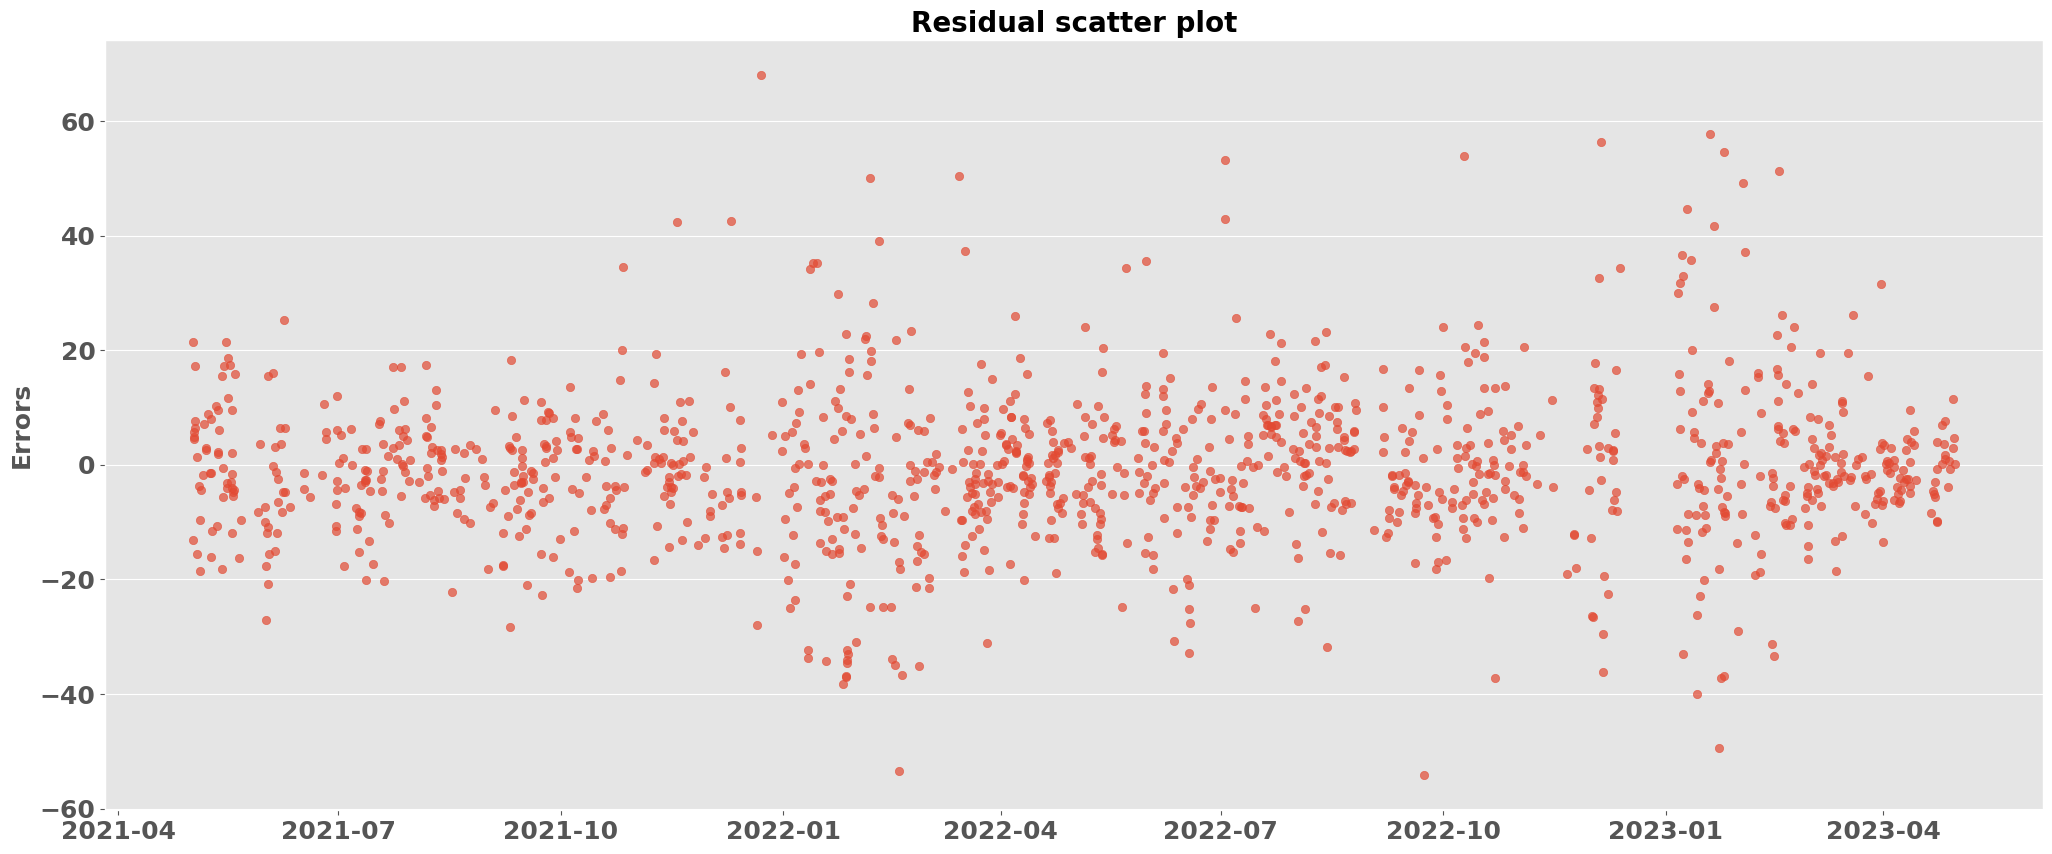

In [ ]:
# calculate the errors
compare_data['Residuals'] = compare_data['Actual PM10'] - compare_data['Predicted PM10']

# make a scatter plot of the errors to see if they follow any pattern
with plt.style.context('ggplot'):
    plt.figure(figsize=(25,10))
    plt.scatter(compare_data.index,compare_data.Residuals,alpha=.7)
    plt.title('Residual scatter plot',fontsize=20, fontweight='bold')
    plt.ylabel('Errors',fontsize=18, fontweight='bold')
    plt.grid(axis='x')
    # Get the current Axes object
    ax = plt.gca()
    # Increase the size of the x and y tick labels
    ax.tick_params(axis='both', which='major', labelsize=18)

    # Set the font weight to bold for x and y tick labels
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.show();

<Figure size 2500x1000 with 0 Axes>

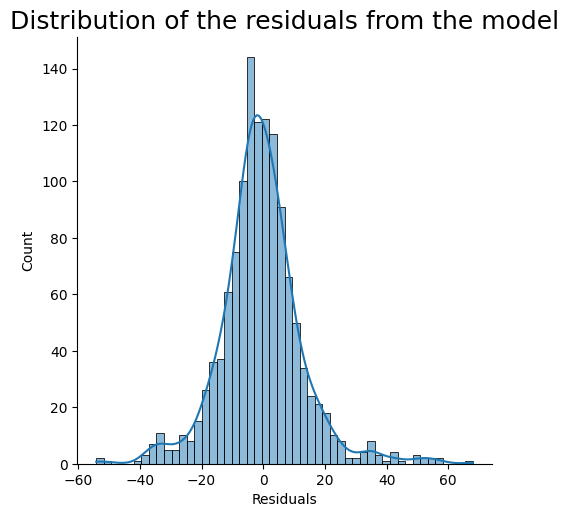

In [ ]:
# plot the histogram to see check the normality of the errors
plt.figure(figsize=(25,10))
sns.displot(compare_data.Residuals,bins=50 , kde = True, lw=5)
plt.title('Distribution of the residuals from the model',
         fontsize=18)
plt.show();